# Network Analysis Project Overview

Network analysis is a discipline of mathematics that is studied to identify relations among social structures through the use of networks and graph theory. For our project, we are broadly interested in exploring network-linked data to explore clustering methods, that is the aggregation of dense groups in our data, building a clustering algorithm to be tested against current clustering methods in practice, as well as exploring advanced visualization techniques to examine the complex relationships in our data. 

**Goal**: We want to investigate our anime network by observing how clusters formed by mutual voice actors in a show can potentially recommend anime shows.

**Motivation**: We're both interested in parts of Japanese culture, with anime being the primary one in particular. Thus, we found this project to be of interest. The methods used can be applicable to other fields of interest as well, since the data is simply just a network.

## Basic Example:

Recall that a graph $G$ is composed of a set $S = \{ N, E\}$, where $N$ represents the set of nodes and $E$ the edges in a graph.

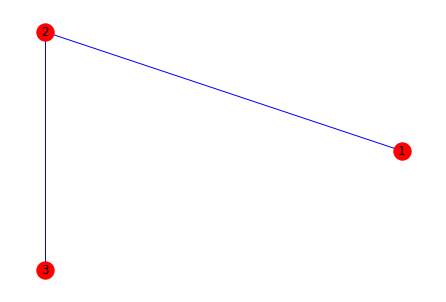

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph() #init graph G (undirected)
G.add_edge(1, 2)  # default edge data=1
G.add_edge(2, 3, weight=0.9)
nx.draw(G, pos=nx.circular_layout(G), node_color='r', edge_color='b', with_labels = True)

# §1. Load Dependencies

We will begin first by loading our libraries into our environment. For our project, we used `networkx` and the standard `pandas` library. For visualizations, we used a combination of `matplotlib` and `dash`.

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# §2. Comparing Spiders

Inspired by our Blog Post 2, we wanted to make an advanced scraper that scraped actors and the shows and movies that they voice acted in. 

> **Error from IMDB Scraper in Blog Post 2: Includes both American and Japanese voice actors**

Temporary Solution: Introduce new condition to check if an actor was born in Japan.


## 2a. All Voice Actors

We begin our project using a scraper that we used in Blog Pot 2 to see how it worked with our show of interest, *Naruto Shippuden*, arguably the most well-known anime across the world (which is also the reason why we picked it as our show of reference). 

In [76]:
def parse_actor_page_all(self, response):
    
        # Iterate through all of the projects
        for project in response.css("div.filmo-category-section")[0].css("b a::text"):
            actor_name = response.css("span.itemprop::text").get() # Get actor name
            movie_or_TV_name = project.get() # Get project title

        # Yield results in a dictionary
            yield {
                "actor" : actor_name,
                "movie_or_TV_name" : movie_or_TV_name
            }

In [8]:
# Run web scraper on imdb site to get voice actor - anime relations

url = "/Users/qianzach/Desktop/GitHub/PIC16B_Project/dash_package/web_scraper/results.csv"
df = pd.read_csv(url)
df.head()

,actor,movie_or_TV_name
0,Maile Flanagan,My Babysitter the Super Hero
1,Maile Flanagan,Work Wife
2,Maile Flanagan,The Loud House
3,Maile Flanagan,Barbie & Kendra Save the Tiger King
4,Maile Flanagan,Boruto: Naruto Next Generations


In [9]:
df.shape

(63145, 2)

We see that our dataset is really big! Upon further review, we noticed that the data is **redundant**. This is because in an anime, there are multiple versions and "dubs" used for countries across the world. 

For example, Maile Flanagan is the voice actor for our beloved ninja, Naruto Uzumaki, in the English version of *Naruto Shippuden*. However, in our dataset, we also see that Junko Takeuchi, the **Japanese** voice actor for Naruto Uzumaki, is also here. 

In [12]:
# Number of unique voice actors
df[df["actor"] == "Junko Takeuchi"].head()

,actor,movie_or_TV_name
375,Junko Takeuchi,Boruto: Naruto Next Generations
383,Junko Takeuchi,100-man no Inochi no Ue ni Ore wa Tatte Iru
384,Junko Takeuchi,Mazica Party
385,Junko Takeuchi,Digimon Adventure: Last Evolution Kizuna
386,Junko Takeuchi,Konosuba!: God's Blessing on This Wonderful Wo...


We are primarily interested in seeing the Japanese voice actors because more voice actors in Japan happen to be voice actors in other anime than the voice actors in English.

**Thus, our next goal was to extract and scrape Japanese voice actors only.**

## 2b. Japanese Voice Actors

To fix, this we filter by scraping only actors that are born in Japan.

In [80]:
def parse_actor_page_japan(self, response):
        
        # If voice actor is from Japan procced
        if response.css("div#name-born-info.txt-block").css("a::text")[2].get().split(", ")[1] == "Japan":
            # Iterate through all of the projects
            for project in response.css("div.filmo-category-section")[0].css("b a::text"):
                actor_name = response.css("span.itemprop::text").get() # Get actor name
                movie_or_TV_name = project.get() # Get project title

            # Yield results in a dictionary
                yield {
                    "actor" : actor_name,
                    "movie_or_TV_name" : movie_or_TV_name
                }
        else:
            pass

In [15]:
# Run web scraper on imdb site to get voice actor - anime relations
# Data = List of directed edges
url = "/Users/qianzach/Desktop/GitHub/PIC16B_Project/dash_package/web_scraper/new_results.csv"
df = pd.read_csv(url)
df.head()

,actor,movie_or_TV_name
0,Kazuhiko Inoue,Granblue Fantasy: Relink
1,Kazuhiko Inoue,Tsukimichi: Moonlit Fantasy
2,Kazuhiko Inoue,Boruto: Naruto Next Generations
3,Kazuhiko Inoue,Bravely Default II
4,Kazuhiko Inoue,Attack on Titan


In [9]:
df.shape

(23055, 2)

Great! We've cut our actors down by a lot. However, we see that our scraper keeps video games, as *Naruto to Bortuo: Shinobi Striker* appears in our data! We want to remove this, as our interest is strictly anime shows!

In [21]:
df.iloc[17:18]

,actor,movie_or_TV_name
17,Kazuhiko Inoue,Naruto to Boruto: Shinobi Striker


Therefore, we provide an extra conditional to test for this.

In [ ]:
def parse_actor_page(self, response):
    """ 
    This parse method starts on the page of an actor and extracts all of the projects 
    that the actor has worked on. Then it yields a dictionary of the actor and the project title.
    """
    # If voice actor is from Japan proceed
    if response.css("div#name-born-info.txt-block").css("a::text")[2].get().split(", ")[1] == "Japan":
        # Iterate through all of the projects
        for project in response.css("div.filmo-category-section")[0].css("div.filmo-row"):
            # If any of the projects are Video Games we skip
            if any("Video Game" in x for x in project.css("*::text").extract()):
                pass 
            else:
                actor_name = response.css("span.itemprop::text").get() # Get actor name
                movie_or_TV_name = project.css("b a::text").get() # Get project title

                # Yield results in a dictionary
                yield {
                    "actor" : actor_name,
                    "movie_or_TV_name" : movie_or_TV_name
                }
    else:
        pass


In [10]:
# Number of unique voice actors
len(df.actor.unique())

186

Our new parser has cut our voice actor count down to 186 total voice actors now!

In [22]:
url = "/Users/qianzach/Desktop/GitHub/PIC16B_Project/dash_package/web_scraper/no_games.csv"
df = pd.read_csv(url)
df.head()

,actor,movie_or_TV_name
0,Chie Nakamura,Boruto: Naruto Next Generations
1,Chie Nakamura,The World's Finest Assassin Gets Reincarnated ...
2,Chie Nakamura,Jujutsu Kaisen
3,Chie Nakamura,Dororo
4,Chie Nakamura,Ace Attorney


# §3. Building a Graph from Data

We wish to build a graph from the data we have. Since we have actors and show names as distinct columns to find connections, we chose to use a *directed graph* (not bidirectional).

In [65]:
# Run web scraper on imdb site to get voice actor - anime relations
# Data = List of directed edges
url = "web_scraper/no_games.csv"
df = pd.read_csv(url)
df.head()

,actor,movie_or_TV_name
0,Chie Nakamura,Boruto: Naruto Next Generations
1,Chie Nakamura,The World's Finest Assassin Gets Reincarnated ...
2,Chie Nakamura,Jujutsu Kaisen
3,Chie Nakamura,Dororo
4,Chie Nakamura,Ace Attorney


### Visualization
Let's visualize the first 350 node-edge pairs. Observe that this is by order of the voice actors, so we only see two voice actors in this subnetwork.

In [90]:
# Let's visualize 100 random relations
DG = nx.from_pandas_edgelist(df.iloc[0:350], 
                             source = "movie_or_TV_name", 
                             target = "actor", 
                             edge_attr=None, 
                             create_using=nx.DiGraph())

To distinguish shows with actors, we will color code the source and target nodes.

In [91]:
colors = []
for node in DG:
    if node in df["actor"].values:
        colors.append("lightblue") # Actor
    else: colors.append("red") # Project Title

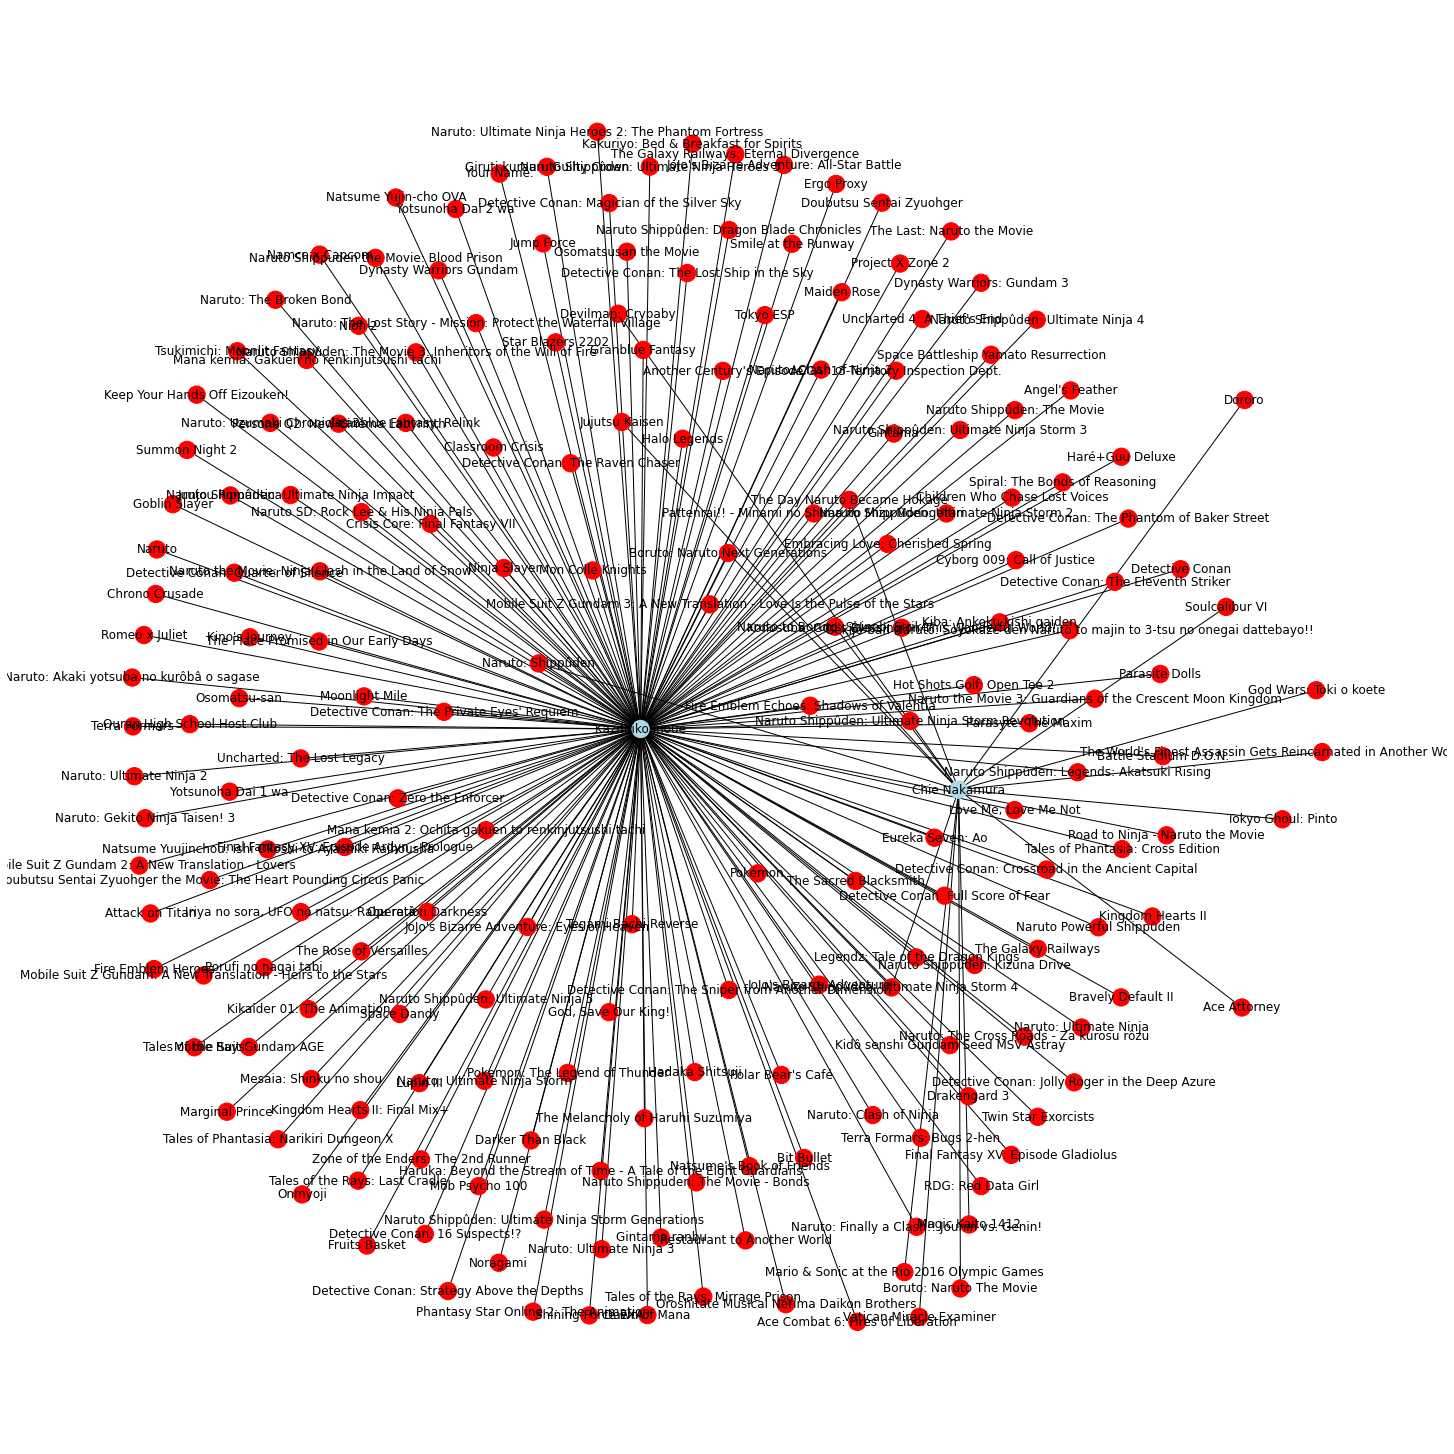

In [34]:
plt.figure(figsize=(20, 20))
pos=nx.spring_layout(DG, k=0.50)
nx.draw(DG, pos, with_labels = True, node_color=colors)

# §4. Exploratory Analysis

## 4a. Centrality
### Node-Centrality

For our first visualization, we based our degree centrality by the total number of edges a given node has, i.e, 

For a given graph $G = (N, E)$ with a total $|N|$ nodes and $|E|$ edges, define a function $\mathcal{C}_D(n)$ as:

$$\mathcal{C}_D(n) = deg(n) \forall n \in N$$

Let's visualize this. For this, higher centrality implies larger node in this graph.

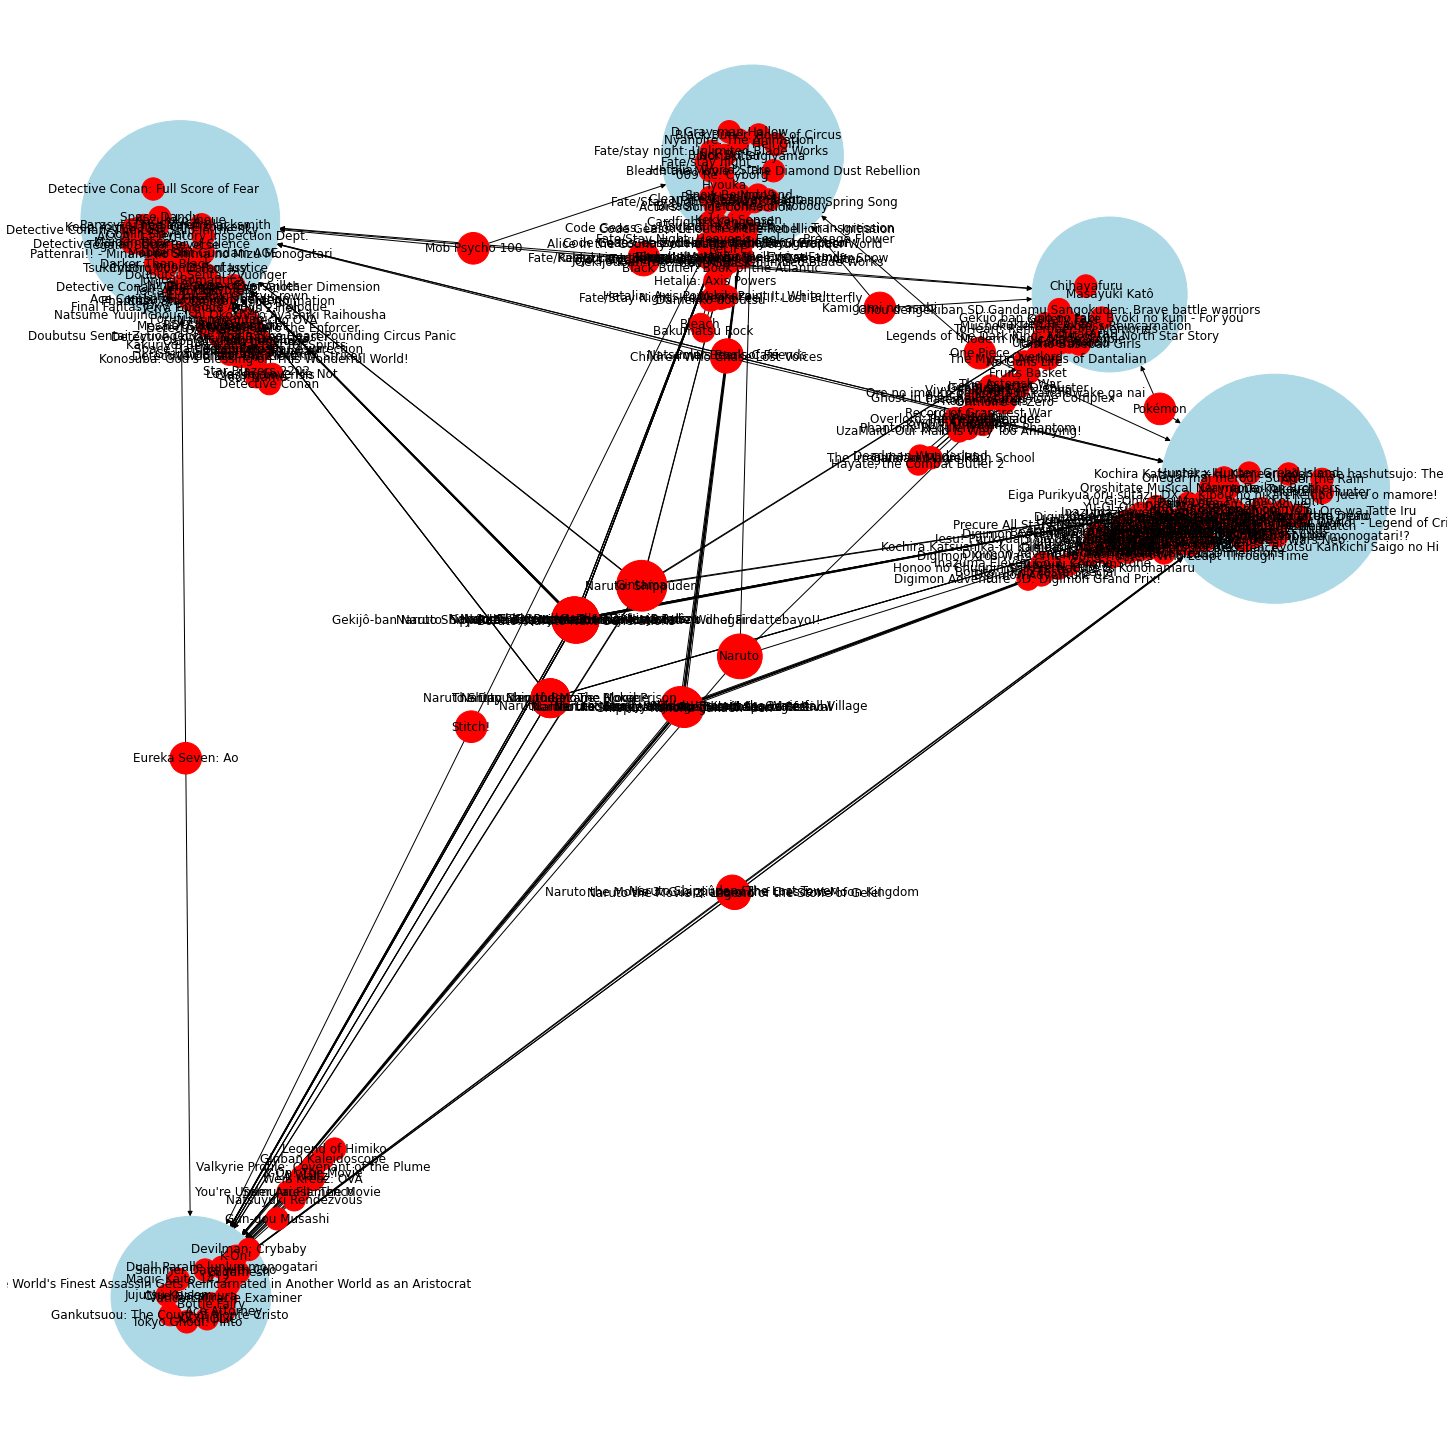

In [93]:
# Visualizing Centrality
deg = DG.degree()
plt.figure(figsize=(20, 20))
layout = nx.layout.fruchterman_reingold_layout(DG)
nx.draw(DG, layout,
        with_labels=True, 
        node_color = colors,
        node_size  = [500*deg[i] for i in DG.nodes()])

Great! We have a visualization. Unfortunately, it's a bit messy. Let's reinvestigate this with our next notebook.